# 3. Survey houses / online experiment

This notebook details the process of **data (houses) selection** for the survey and the creation of the **experimental interface**.

In [2]:
import sys
import os
import yaml
import glob

import pandas as pd
import numpy as np

from datetime import datetime

from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

import ipywidgets as widgets
from IPython.display import display
# from interpret import show

#import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

import warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")

In [3]:
sys.path.append(os.path.abspath(".."))
from src import calculate_coverage, get_conformalized_interval

## 1. Data selection

### 1.1 _California housing_ dataset

In [4]:
# Import data
df_california = fetch_california_housing(as_frame=True)

df = df_california.frame
df['Longitude'] = df['Longitude'].round(2)
df['Latitude'] = df['Latitude'].round(2)
df['MedHouseVal'] = df['MedHouseVal'].round(5)

X = pd.DataFrame(df_california.data, columns=df_california.feature_names)
y = df_california.target
n = len(y)

In [5]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### 1.2 Model fit

In [6]:
# Random seed to ensure reproducibility of the data selection process (dataset split and model estimation):
seed = 42

In [7]:
# Dataset split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=seed)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=seed)
print(f"Proportion training set: {len(X_train)/len(X):.2f}")
print(f"Proportion test set: {len(X_test)/len(X):.2f}")
print(f"Proportion calibration set: {len(X_calib)/len(X):.2f}")

Proportion training set: 0.60
Proportion test set: 0.20
Proportion calibration set: 0.20


In [8]:
# Model fit and predict with default hyperparameters
ebm_model = ExplainableBoostingRegressor(random_state=seed)
ebm_model.fit(X_train, y_train)

# Predictions
y_pred_train = ebm_model.predict(X_train)
y_pred_calib = ebm_model.predict(X_calib)
y_pred_test = ebm_model.predict(X_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"RMSE on the training set: {rmse_train:.3f}")
print(f"RMSE on the test set: {rmse_test:.3f}")

RMSE on the training set: 0.418
RMSE on the test set: 0.482


#### 1.2.1 Residual analysis

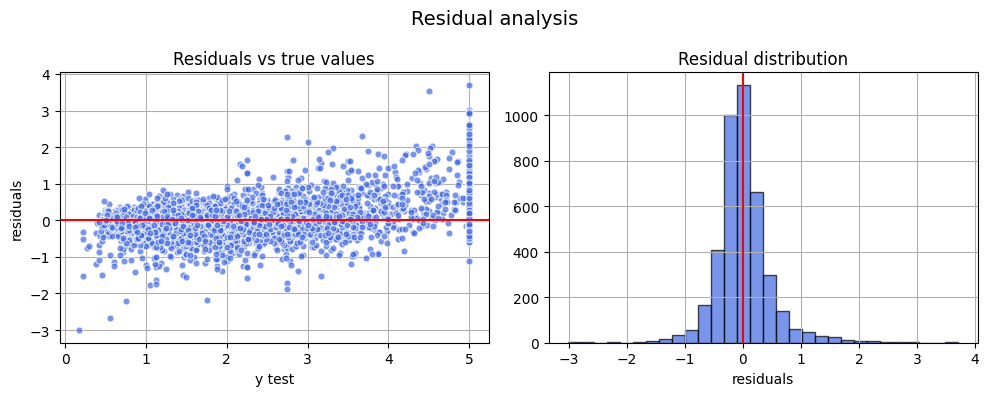

In [9]:
# Residual analysis

fig_resid, ax_resid = plt.subplots(1, 2, figsize=(10, 4))
ax_resid[0].plot(
    y_test, (y_test-y_pred_test), ls='', marker='o', markersize=5, alpha=0.7, color='royalblue',
    markeredgecolor="white", markeredgewidth=0.8
)
ax_resid[0].axhline(0, color='red', ls='-')
ax_resid[0].grid()
ax_resid[0].set_xlabel('y test')
ax_resid[0].set_ylabel('residuals')
ax_resid[0].set_title('Residuals vs true values')

ax_resid[1].hist((y_test-y_pred_test), bins=30, edgecolor="black", alpha=0.7, color='royalblue')
ax_resid[1].axvline(0, color='red', ls='-')
ax_resid[1].grid()
ax_resid[1].set_xlabel('residuals')
ax_resid[1].set_title('Residual distribution')

plt.suptitle('Residual analysis', fontsize=14)
plt.tight_layout()
plt.show()

**Note:** The _California housing_ dataset is known to be *capped* at a maximum median house value of 5.0 (≈ \$500 000). As a result, observations at this upper bound show larger residuals, since the true prices exceed the recorded limit. This censoring effect explains the visible concentration of residuals around 5 in the plot.

#### 1.2.2 Feature importance
The visualization below shows **global feature importance** as derived from the EBM model. Feature importance in EBM does _not_ represent simple correlation with the target variable. Instead, it measures each feature’s **contribution to the model’s predictions** (how much the predicted value changes when the feature varies, according to the model’s learned shape functions). This plot shows which features the model relies on most across the entire dataset, providing a **global explanation** of the model’s behavior.

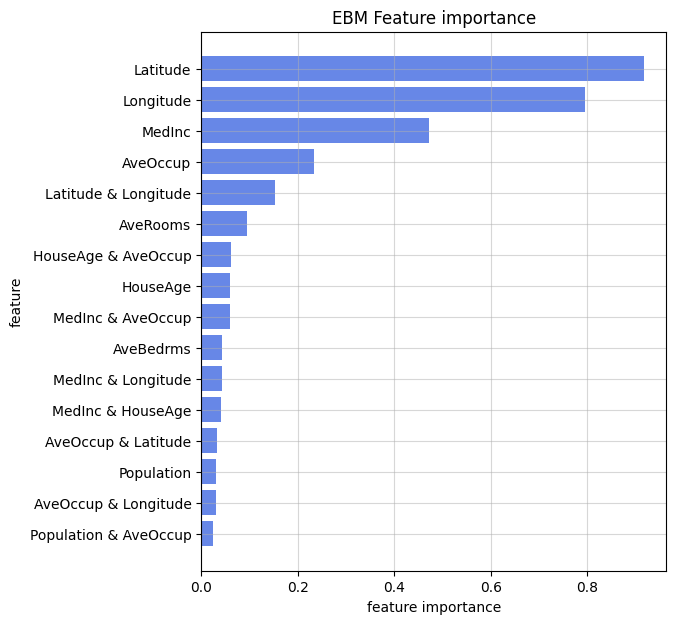

In [10]:
# Global explanation

# Interactive dashboard
# global_explanation = ebm_model.explain_global()
# show(global_explanation)

global_exp = ebm_model.explain_global()
df_ebm_feat_imp = pd.DataFrame(global_exp.data()).sort_values(by='scores')

# Plot feature importance
fig_feat_imp, ax_feat_imp = plt.subplots(figsize=(6, 7))

ax_feat_imp.barh(df_ebm_feat_imp["names"], df_ebm_feat_imp["scores"], color="royalblue", alpha=0.8)
ax_feat_imp.set_xlabel("feature importance")
ax_feat_imp.set_ylabel("feature")
ax_feat_imp.set_title("EBM Feature importance")
ax_feat_imp.grid(alpha=0.5)

#fig_feat_imp.tight_layout()
plt.show()

In [11]:
# Local explanation (why a single prediction was made)
# Interactive dashboard
# local_explanation = ebm_model.explain_local(X_test_houses, y_test_houses)
# show(local_explanation)

### 1.3 Data (house) selection
To select houses for the survey that span a range of **prediction accuracies**, we first rank them by their absolute residuals (`y_true − y_pred`). Our goal here is to define three difficulty levels: `easy`, `medium`, and `hard`, based on model accuracy. We look at the **quantiles** of the residual distribution to guide this process. The histogram below shows the distribution across the test set, with the **75th** and **95th percentiles** (dashed lines) marking the thresholds for house selection.

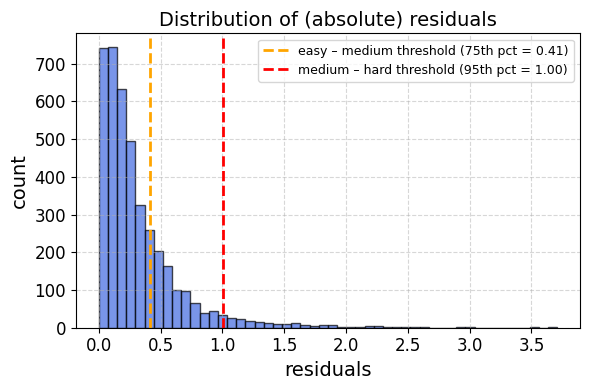

In [12]:
# Compute quantile thresholds
q1 = (np.abs(y_test-y_pred_test)).quantile(0.75)
q2 = (np.abs(y_test-y_pred_test)).quantile(.95)

# Plot
fig_err, ax_err = plt.subplots(figsize=(6, 4))
ax_err.hist((np.abs(y_test-y_pred_test)), bins=50, color="royalblue", edgecolor="black", alpha=0.7)

# Add threshold lines
ax_err.axvline(q1, color="orange", linestyle="--", linewidth=2,
               label=f"easy – medium threshold (75th pct = {q1:.2f})")
ax_err.axvline(q2, color="red", linestyle="--", linewidth=2,
               label=f"medium – hard threshold (95th pct = {q2:.2f})")

ax_err.set_title("Distribution of (absolute) residuals", fontsize=14)
ax_err.set_xlabel("residuals", fontsize=14)
ax_err.set_ylabel("count", fontsize=14)
ax_err.legend(fontsize=9)
ax_err.grid(alpha=0.5, linestyle="--")
ax_err.tick_params(axis="both", which="major", labelsize=12)

fig_err.tight_layout()
plt.show()

Rather than random sampling, we prefered a **targeted (manual) approach** to also ensure geographic diversity and balanced coverage across the target variable range. Below is the dataset of the nine selected houses, each described by its name, location, true value, and complexity level (`easy`, `medium`, `hard`).

In [13]:
# Load yaml houses file (manually selected)
# complexity refers to the prediction error magnitude, classified into three possible groups
with open("../src/houses.yml", "r") as f:
    dict_houses = yaml.safe_load(f)

df_houses = pd.DataFrame(dict_houses)

df_houses['longitude'] = df_houses['longitude'].round(2)
df_houses['latitude'] = df_houses['latitude'].round(2)
df_houses['true_value'] = df_houses['true_value'].round(5)
df_houses

,name,longitude,latitude,true_value,complexity
0,Artemisstreet,-121.49,39.49,0.88900,easy
1,Aphroditestreet,-124.11,40.95,0.81700,easy
2,Apollostreet,-122.18,37.80,3.18200,easy
3,Athenastreet,-122.27,37.82,1.12500,medium
4,Poseidonstreet,-118.35,34.10,3.72200,medium
5,Aresstreet,-118.32,33.77,5.00001,medium
6,Zeusstreet,-117.08,34.08,5.00001,hard
7,Hephaestusstreet,-120.92,37.63,4.50000,hard
8,Hestiastreet,-118.33,34.15,0.17500,hard


In [14]:
# Merge with complete df
df_house_match = pd.merge(
    df,
    df_houses,
    left_on=["MedHouseVal", "Longitude", "Latitude"],
    right_on=["true_value", "longitude", "latitude"],
    how="left"
)

# Indexes of selected houses
idx_house_match = df_house_match.index[df_house_match['name'].notna()].tolist()

# Filtered y and X
y_test_houses = y_test[y_test.index.isin(idx_house_match)]
X_test_houses = X_test[X_test.index.isin(idx_house_match)]

In [15]:
# Get prediction error for sel. houses
df_test_pred = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred_test
})

df_test_pred['pred_error'] = np.abs(
    df_test_pred['y_test'] - df_test_pred['y_pred']
)

df_test_pred["sel_houses"] = df_test_pred["y_test"].index.isin(idx_house_match)
df_test_pred = df_test_pred.sort_values(by='pred_error') #.reset_index(drop=True)
sort_idx_true = df_test_pred.index[df_test_pred["sel_houses"] == True]

# Display info
df_house_info = df_house_match[df_house_match.name.notna()][list(df_houses.columns)] #.sort_values(by='difficulty_level')
df_house_info.join(df_test_pred.drop(['y_test', 'sel_houses'], axis=1)).loc[sort_idx_true].set_index('name')

,longitude,latitude,true_value,complexity,y_pred,pred_error
name,,,,,,
Artemisstreet,-121.49,39.49,0.88900,easy,0.989713,0.100713
Aphroditestreet,-124.11,40.95,0.81700,easy,1.025909,0.208909
Apollostreet,-122.18,37.80,3.18200,easy,3.583212,0.401212
Poseidonstreet,-118.35,34.10,3.72200,medium,2.729774,0.992226
Athenastreet,-122.27,37.82,1.12500,medium,2.127884,1.002884
Aresstreet,-118.32,33.77,5.00001,medium,3.989256,1.010754
Hestiastreet,-118.33,34.15,0.17500,hard,3.186716,3.011716
Hephaestusstreet,-120.92,37.63,4.50000,hard,0.975712,3.524288
Zeusstreet,-117.08,34.08,5.00001,hard,1.292537,3.707473


### 1.4 Visualization of the selected house

In [16]:
# Save data
save_dfs = True
output_folder_path = '../data/output/houses_predictions/'

alphas = [0.001, 0.01, 0.05, 0.1, 0.2] #[::-1]

if save_dfs == True:
    now = datetime.now()
    print("Last run:", now)
    for alpha in alphas: 
        conf_lower_bound, conf_upper_bound = get_conformalized_interval(
            y_test_pred=y_pred_test, 
            y_calib_pred=y_pred_calib,
            y_calib=y_calib,
            alpha=alpha
        )
        df_test = pd.DataFrame(data={
            'lower_bound': conf_lower_bound,
            'upper_bound': conf_upper_bound,
            'y_test': y_test,
            'y_test_pred': y_pred_test
        })

        # Adding house attributes
        df_test = X_test.join(df_test)

        # Adding info about houses
        df_test_house = pd.merge(
            df_test,
            df_houses,
            left_on=["y_test", "Longitude", "Latitude"],
            right_on=["true_value", "longitude", "latitude"],
            how="inner"
        )

        # Drop duplicated columns
        df_test_house = df_test_house.drop(["true_value", "longitude", "latitude"], axis=1)

        df_to_save = df_test_house #[df_test_house.name.notna()]

        if len(df_to_save)==9:
            print(f'Saving dataset for alpha {alpha}')
            df_to_save.to_csv(output_folder_path + f'houses_conformal_{str(alpha).replace(r'0.', '')}.csv', index=False)

Last run: 2025-12-02 15:08:34.494315
Saving dataset for alpha 0.001
Saving dataset for alpha 0.01
Saving dataset for alpha 0.05
Saving dataset for alpha 0.1
Saving dataset for alpha 0.2


In [17]:
# Read data
def load_house_predictions(folder=output_folder_path):
    dataframes = {}
    # Local environment – read from filesystem
    csv_files = glob.glob(os.path.join(folder, "houses_conformal_*.csv"))
    for file in csv_files:
        basename = os.path.basename(file)
        alpha = basename.replace("houses_conformal_", "").replace(".csv", "")
        df = pd.read_csv(file)
        dataframes[alpha] = df
    return dataframes

dataframes = load_house_predictions()

In [18]:
# Houses and their classification in terms of prediction error with standard confidence level of 0.05

df_plot_houses = dataframes['05'] 
# pd.read_csv("data/output/houses_conformal_predictions/houses_conformal_05.csv")

# Convert the column to a categorical with the specified order
df_plot_houses['complexity'] = pd.Categorical(df_plot_houses['complexity'], categories=['easy', 'medium', 'hard'], ordered=True)
df_plot_houses = df_plot_houses.sort_values(by='complexity', ascending=False)

df_plot_houses['lower_diff'] = df_plot_houses['y_test_pred'] - df_plot_houses['lower_bound']
df_plot_houses['upper_diff'] = df_plot_houses['upper_bound'] - df_plot_houses['y_test_pred']

df_plot_houses['abs_error'] = np.abs(df_plot_houses['y_test'] - df_plot_houses['y_test_pred'])
df_plot_houses = df_plot_houses.sort_values(by=['abs_error', 'complexity'], ascending=[False, False])

df_plot_houses = df_plot_houses.reset_index(drop=True)

df_plot_houses

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,lower_bound,upper_bound,y_test,y_test_pred,name,complexity,lower_diff,upper_diff,abs_error
0,3.0625,34.0,3.214286,0.785714,39.0,2.785714,34.08,-117.08,0.292131,2.292944,5.00001,1.292537,Zeusstreet,hard,1.000407,1.000407,3.707473
1,1.7679,39.0,5.000000,0.888889,22.0,2.444444,37.63,-120.92,-0.024694,1.976119,4.50000,0.975712,Hephaestusstreet,hard,1.000407,1.000407,3.524288
2,2.3667,39.0,3.572464,1.217391,259.0,1.876812,34.15,-118.33,2.186310,4.187123,0.17500,3.186716,Hestiastreet,hard,1.000407,1.000407,3.011716
3,6.8870,37.0,5.915094,0.896226,259.0,2.443396,33.77,-118.32,2.988849,4.989662,5.00001,3.989256,Aresstreet,medium,1.000407,1.000407,1.010754
4,1.7750,40.0,2.687500,1.065341,700.0,1.988636,37.82,-122.27,1.127477,3.128290,1.12500,2.127884,Athenastreet,medium,1.000407,1.000407,1.002884
5,2.6458,16.0,2.989796,1.059184,1648.0,1.681633,34.10,-118.35,1.729368,3.730181,3.72200,2.729774,Poseidonstreet,medium,1.000407,1.000407,0.992226
6,6.2838,34.0,6.948718,1.000000,442.0,2.266667,37.80,-122.18,2.582806,4.583619,3.18200,3.583212,Apollostreet,easy,1.000407,1.000407,0.401212
7,2.9600,19.0,5.070175,1.067251,866.0,2.532164,40.95,-124.11,0.025502,2.026315,0.81700,1.025909,Aphroditestreet,easy,1.000407,1.000407,0.208909
8,2.9965,20.0,5.839161,1.090909,1174.0,2.736597,39.49,-121.49,-0.010694,1.990119,0.88900,0.989713,Artemisstreet,easy,1.000407,1.000407,0.100713


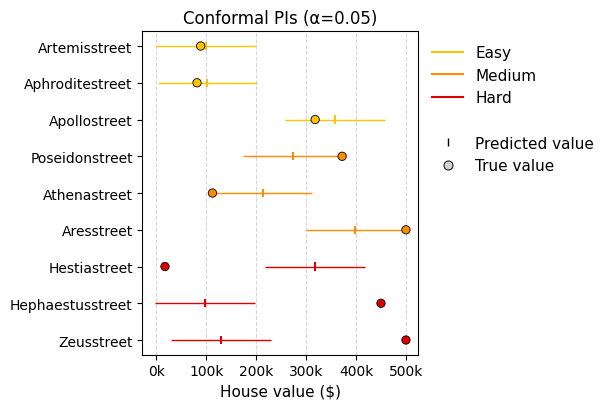

In [19]:
color_map = {
    'easy': '#fdc500',
    'medium': '#fd8c00',
    'hard': '#dc0000'
}

# Visualize the color map
# sns.palplot([color_map[key] for key in color_map])
# plt.show()

fig_0, ax_0 = plt.subplots(1, 1, figsize=(6.2, 4.2))

y_positions = range(len(df_plot_houses))

# Prediction intervals
for i_row, row in enumerate(df_plot_houses.itertuples()):
    ax_0.hlines(
        y=i_row,
        xmin=row.lower_bound,
        xmax=row.upper_bound,
        alpha=1,
        linewidth=1,
        color=color_map[row.complexity]
    )

ax_0.scatter(
    df_plot_houses.y_test_pred, y_positions,
    marker='|',
    c=list(df_plot_houses.complexity.map(color_map))
)

ax_0.scatter(
    df_plot_houses.y_test, y_positions,
    marker='o',
    s=36,
    c=list(df_plot_houses.complexity.map(color_map)),
    #facecolors='white',        # white fill
    edgecolors='black',        # black border
    linewidth=0.6,
    zorder=3
)

ax_0.set_yticks(y_positions, df_plot_houses.name)
#handles = [mpatches.Patch(color=color_map[c], label=c) for c in color_map]
#ax_0.legend(title='Prediction error', handles=handles)

# Legend
# handles = [mpatches.Patch(color=color_map[c], label=f'{c}') for c in color_map]
# segment: 
handles = [
    Line2D(
        [0], [0],
        color=color_map['easy'],
        lw=1.5,
        label='Easy'
    ),
    Line2D(
        [0], [0],
        color=color_map['medium'],
        lw=1.5,
        label='Medium'
    ),
    Line2D(
        [0], [0],
        color=color_map['hard'],
        lw=1.5,
        label='Hard'
    )
]

# Add a handle for true values
handles.append(Line2D([0], [0], color='gray', lw=1, linestyle='None', label=''))
handles.append(Line2D([0], [0], marker='|', color='black', linestyle='', label='Predicted value'))
handles.append(Line2D([0], [0], marker='o', markerfacecolor='lightgray', markeredgecolor='black', linestyle='', label='True value', markeredgewidth=0.7, markersize=6.5))

ax_0.legend(
    # title='How to read',
    handles=handles,
    fontsize=11,
    loc='upper left',
    frameon=False,
    bbox_to_anchor=(1.0, 1)  # shift outside
)

plt.xticks(
    np.arange(0, 5.1, 1), 
    [f"{int(x)*100}k" for x in np.arange(0, 5.1, 1)]
)
plt.xlabel("House value ($)", fontsize=11)
plt.title('Conformal PIs (α=0.05)', fontsize=12) # (sorted by prediction error)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [20]:
delta_dict = {}
for score in alphas:
    score_str = str(score).replace('0.', '')
    df_plot_houses_score = dataframes[score_str] 
    delta_dict[score_str] = (df_plot_houses_score['y_test_pred'] - df_plot_houses_score['lower_bound']).values[0]

deltas = [delta_dict[k.replace('.', '')] for k in ["001", "01", "05", "1", "2"]]
print("alphas:", alphas)
print("deltas:", [f"{d:.3f}" for d in deltas])

alphas: [0.001, 0.01, 0.05, 0.1, 0.2]
deltas: ['2.979', '1.715', '1.000', '0.735', '0.494']


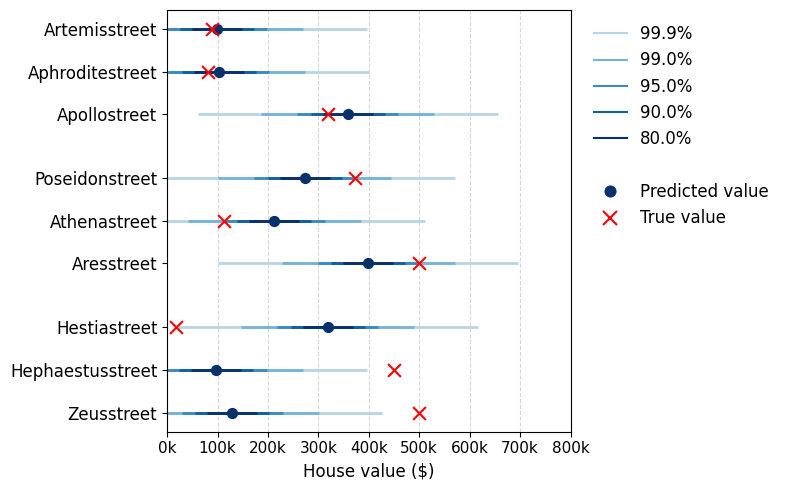

In [21]:
# Preferred version used in the paper
blue_colors = plt.cm.Blues(np.linspace(0.3, 1, len(alphas)))
darkest_blue = blue_colors[-1]
darkest_blue_hex_code = mcolors.to_hex(darkest_blue)
# Visualize colors
# sns.palplot(blue_colors)
# plt.show()

fig_houses, ax_houses = plt.subplots(figsize=(8, 5))

n_houses = len(df_plot_houses)
y_pos = np.arange(n_houses)

offset_step = 0.12 
start_offset = -(len(alphas) - 1) / 2 * offset_step

group_size = 3
gap = 0.5
y_pos = np.arange(n_houses) + (np.arange(n_houses) // group_size) * gap

for _i in range(n_houses):
    pred = df_plot_houses.y_test_pred[_i]
    for _j, _alpha in enumerate(alphas):
        delta = deltas[_j]
        lo = pred - delta
        hi = pred + delta
        y_val = y_pos[_i] #+ start_offset + _j * offset_step
        ax_houses.hlines(y_val, lo, hi, color=blue_colors[_j], linewidth=2)

ax_houses.scatter(
    df_plot_houses.y_test_pred,
    y_pos,
    marker='o',
    s=50,
    facecolors=darkest_blue_hex_code,
    zorder=3
)

ax_houses.scatter(
    df_plot_houses.y_test,
    y_pos,
    marker='x',
    s=85,
    facecolors='red',  
    linewidth=1.5,
    zorder=3
)

ax_houses.set_xlabel("House value ($)", fontsize=12)
#ax_houses.set_title("Prediction intervals per house", fontsize=12)
ax_houses.grid(axis='x', linestyle='--', alpha=0.5)
ax_houses.set_yticks(y_pos, df_plot_houses.name, fontsize=12)
ax_houses.set_xlim(0, 8)
plt.xticks(
    np.arange(0, 8.1, 1), 
    [f"{int(x)*100}k" for x in np.arange(0, 8.1, 1)],
    fontsize=11
)

labels_alpha = [f'α = {alpha:.3f}' for i, alpha in enumerate(alphas)]
labels_coverage = ['99.9%', '99.0%', '95.0%', '90.0%', '80.0%']
handles_houses = [
    Line2D([0], [0], color=blue_colors[i], lw=1.5, label=labels_coverage[i])
    for i in range(len(alphas))
]

# add the custom legend elements
handles_houses += [
    Line2D([0], [0], color='white', lw=1, label=''),  # spacer (optional)
    Line2D(
        [0], [0],
        marker='o',
        markerfacecolor=darkest_blue_hex_code,\
        markeredgecolor=darkest_blue_hex_code,
        linestyle='',
        label='Predicted value',
        markeredgewidth=0.7,
        markersize=8
    ),
    Line2D([0], [0], marker='x', markersize=10, markeredgewidth=1.5, markeredgecolor='red', linestyle='', label='True value')
]

ax_houses.legend(
    handles=handles_houses,
    fontsize=12,
    loc='upper left',
    frameon=False,
    bbox_to_anchor=(1.02, 1)  # shift outside
)

plt.tight_layout()
plt.savefig("../figures/house_predictions.pdf")#, dpi=600)
plt.show()

## 2. Survey interface

In [6]:
list_model_houses = [
    'Artemisstreet', 'Aphroditestreet', 'Apollostreet', 
    'Hephaestusstreet', 'Athenastreet', 'Poseidonstreet',
    'Aresstreet', 'Hestiastreet', 'Zeusstreet'
]

dropdown_house = widgets.Dropdown(
    options=list_model_houses,
    value='Artemisstreet',
    description='Select a house:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='300px')
)

display(dropdown_house)

Dropdown(description='Select a house:', layout=Layout(width='300px'), options=('Artemisstreet', 'Aphroditestre…

In [84]:
pred_error = df_houses[df_houses.name==dropdown_house.value].complexity.values[0]
print(f'The selected house is in the `{pred_error}` complexity group.')

The selected house is in the `easy` complexity group.


### 2.1 Context view

In [85]:
context_view_folder_path = "../figures/context_view/"

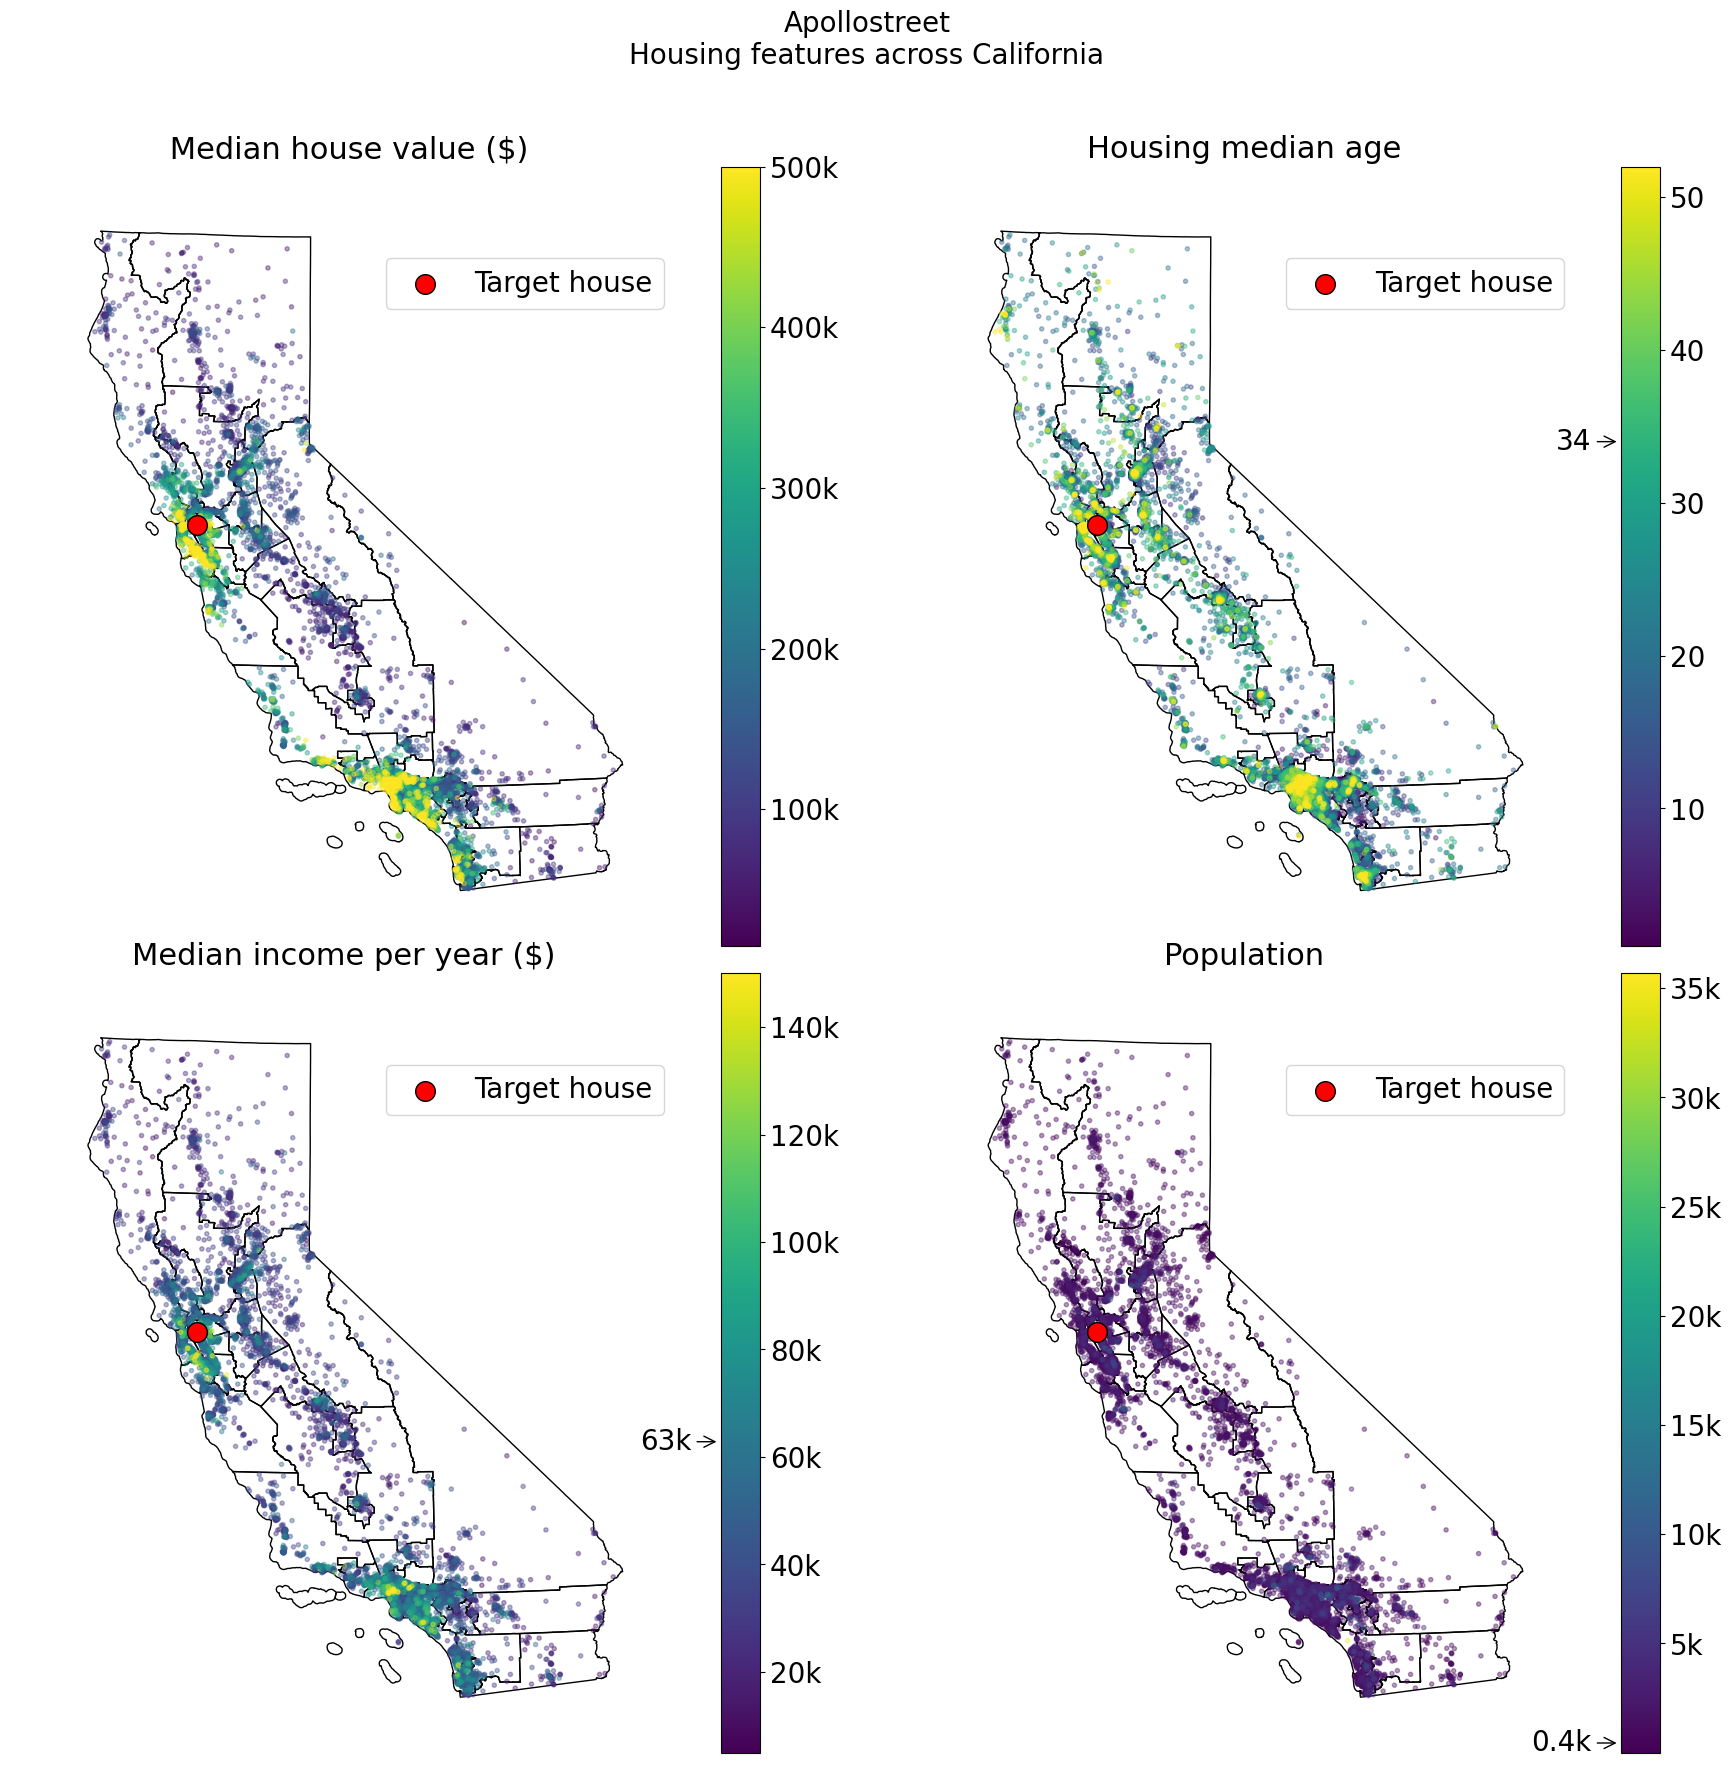

In [86]:
cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
# cali = cali.to_crs(epsg=3310) # # Reproject to a suitable projected CRS (California Albers)
cali = cali.assign(area=cali.geometry.area) # area in square meters
# If you want square kilometers:
# cali["area_km2"] = cali["area"] / 1e6

# General config
cols = ['MedHouseVal', 'HouseAge', 'MedInc', 'Population']
cols_renaming = {
    'MedHouseVal': ' Median house value ($)', 
    'HouseAge': 'Housing median age',
    'MedInc': 'Median income per year ($)',
    'Population': 'Population'
}
df_train = X_train.join(y_train)
df_train['MedInc'] = df_train['MedInc']*10 # scaled

arrow_vals = df_plot_houses[df_plot_houses.name==dropdown_house.value].rename(columns={'y_test': 'MedHouseVal'})[cols]
arrow_vals['MedInc'] = arrow_vals['MedInc']*10
arrow_vals_rounded = [round(float(v), 2) for v in arrow_vals.values.flatten()]
arrow_vals_rounded[0] = None

# Define single house data
house = [el for el in dict_houses if el['name'] == dropdown_house.value][0]

house_gdf = gpd.GeoDataFrame(
    [house],
    geometry=gpd.points_from_xy([house["longitude"]], [house["latitude"]]),
    crs="EPSG:4326"
)

# input coordinates are in lat/lon (EPSG:4326):
gdf = gpd.GeoDataFrame(
    df_train.copy(), 
    geometry=gpd.points_from_xy(df_train.Longitude, df_train.Latitude),
    crs="EPSG:4326"
) # GeoDataFrame
proj = gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944)

fig, axes = plt.subplots(2, 2, figsize=(18, 18), subplot_kw={'projection': proj})
axes = axes.flatten()

for j, col in enumerate(cols):
    ax = axes[j]
    tgdf = gdf.sort_values(by=col)
    gplt.polyplot(cali, projection=proj, ax=ax)
    pointplot = gplt.pointplot(tgdf, ax=ax, hue=col, cmap='viridis', legend=True, alpha=0.4, s=3)
    house_proj = house_gdf.to_crs(ax.projection)

    ax.scatter(
        house_proj.geometry.x,
        house_proj.geometry.y,
        color='red',
        s=200,
        marker='o',
        edgecolor='black',
        label='Target house',
        zorder=5
    )

    cbar = pointplot.get_figure().axes[-1]
    cbar.tick_params(labelsize=20)

    if col == "MedHouseVal":
        formatter = mticker.FuncFormatter(lambda x, pos: f'{int(x)*100}k')
        cbar_format_ax = cbar 
        cbar_format_ax.yaxis.set_major_formatter(formatter)  

    if col == "MedInc":
        formatter = mticker.FuncFormatter(lambda x, pos: f'{int(x)}k')
        cbar_format_ax = cbar 
        cbar_format_ax.yaxis.set_major_formatter(formatter)  

    if col == "Population":
        formatter = mticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k')
        cbar_format_ax = cbar 
        cbar_format_ax.yaxis.set_major_formatter(formatter)  

    if arrow_vals_rounded[j] is not None:
        cbar = plt.gcf().axes[-1]
        val = arrow_vals_rounded[j]
        norm = plt.Normalize(vmin=tgdf[col].min(), vmax=tgdf[col].max())
        frac = np.clip(norm(val), 0, 1)
        if col == "HouseAge":
            label_val = f'{val:.0f}'
        if col == "Population":
            label_val = f'{val/1000:.1}k'
        if col == "MedInc":
            label_val = f'{val:.0f}k'
        cbar.annotate(
            label_val,
            xy=(-0.05, frac),
            xycoords='axes fraction',
            xytext=(-20, 0),
            textcoords='offset points',
            ha='right',
            va='center',
            fontsize=20,
            color='black',
            arrowprops=dict(arrowstyle="->", color='black', linewidth=1)
        )
    ax.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1, 0.90))
    ax.set_title(cols_renaming[col], fontsize=22)

#plt.suptitle("Housing features across California", fontsize=20, y=1.02)

plt.suptitle(f"{dropdown_house.value}\nHousing features across California", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# ax.set_rasterized(True)
plt.savefig(context_view_folder_path + f"house_features_{dropdown_house.value.lower()}.pdf")
# plt.savefig(context_view_folder_path + f"png/house_features_{dropdown_house.value.lower()}.png", dpi=200, bbox_inches="tight")
plt.show()

### 2.2 Uncertainty visualizations

In [26]:
mcb_vis_folder_path = "../figures/uncertainty_vis/mcb/" # multilevel confidence bands
geb_vis_folder_path = "../figures/uncertainty_vis/geb/" # graded error bars

In [27]:
visualize_house = widgets.Dropdown(
    options=['no', 'yes'],
    value='yes',
    description='Do you want to visualize the selected house?',
    style={'description_width': '280px'},
    layout=widgets.Layout(width='350px')
)

display(visualize_house)

Dropdown(description='Do you want to visualize the selected house?', index=1, layout=Layout(width='350px'), op…

In [28]:
bool_add_house = True if visualize_house.value=='yes' else False
bool_add_house

True

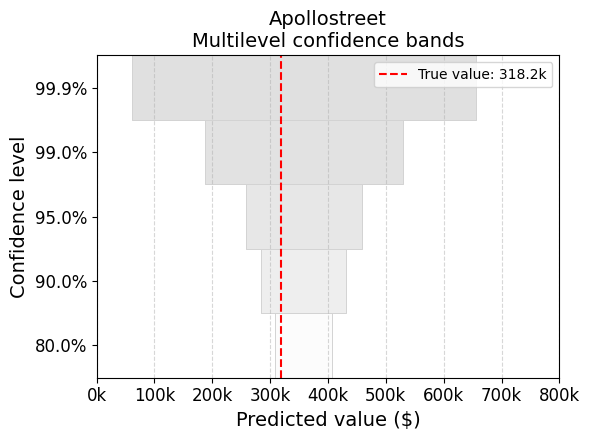

In [60]:
# Setup
bar_height = 1.0  # Height of each confidence level block

# Setup the updated grayscale range
start_gray_updated = 0.99 # 0.99
end_gray_final = 0.88 # 0.88

# Calculate normalized confidence deltas
confidences = [1 - alpha for alpha in alphas[::-1]]
conf_deltas_norm = (np.array(confidences) - min(confidences)) / (max(confidences) - min(confidences))

# Calculate final adjusted grayscale values
grayscale_final_adjusted = start_gray_updated - conf_deltas_norm * (start_gray_updated - end_gray_final)

# -----
# Chart 

#fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

for i, (alpha_sel, gray_value) in enumerate(zip(alphas[::-1], grayscale_final_adjusted)):

    # Filtering df
    df_alpha = dataframes[str(alpha_sel).replace('0.', '')]
    df_plot = df_alpha[df_alpha.name==dropdown_house.value]
    y_pred = df_plot["y_test_pred"].values[0] * 100
    lower_bound = df_plot["lower_bound"].values[0] * 100
    upper_bound = df_plot["upper_bound"].values[0] * 100

    # Use the new refined grayscale color
    color = (gray_value, gray_value, gray_value)

    # Teken shaded confidence interval blok
    ax.fill_betweenx(
        [i * bar_height, (i + 1) * bar_height],
        lower_bound,
        upper_bound,
        color=color,
        edgecolor="lightgray",
        linewidth=0.7
    )
    # Y-as labels: confidence levels
    confidence_labels = []
    for cl in confidences:
        if abs(cl - 0.999) < 0.0001:
            confidence_labels.append("0.999")
        else:
            confidence_labels.append(f"{cl:.2f}")

# Plot the true value as a vertical red line
y_true_scaled = df_plot.y_test.values[0] * 100
if bool_add_house:
    plt.axvline(
        x=y_true_scaled, 
        color='red', linestyle='--', linewidth=1.5, 
        label=f'True value: {y_true_scaled:.1f}k'
    )

plt.ylabel("Confidence level", fontsize=14)
plt.xlabel("Predicted value ($)", fontsize=14)
plt.yticks(
    np.arange(len(alphas)) * bar_height + bar_height / 2, 
    labels=[f'{np.around(float(el)*100, 1)}%' for el in confidence_labels],
    fontsize=12
)
plt.ylim(0, len(alphas) * bar_height)
plt.xlim(0, 800)
plt.xticks(
    ticks=np.arange(0, 801, 100),
    labels=[f"{int(x)}k" for x in np.arange(0, 801, 100)],
    fontsize=12
)

title = f'{dropdown_house.value}\nMultilevel confidence bands' #if bool_add_house else 'Multilevel confidence bands'
plt.title(title, fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)

if bool_add_house:
    plt.legend(loc="upper right")
    
plt.tight_layout()

save_fig_name = f"mcb_{dropdown_house.value.lower()}.pdf"
# save_fig_name = "mcb_example.pdf"
plt.savefig(mcb_vis_folder_path + save_fig_name)

plt.show()

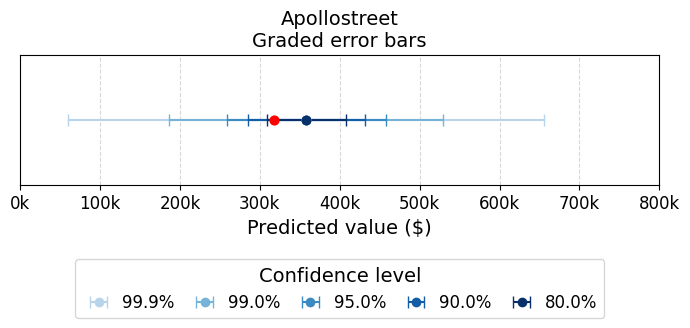

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))

colors = plt.cm.Blues(np.linspace(0.3, 1, len(alphas)))
fixed_y = 0  # All error bars are plotted on the same y-axis value
scale_factor = 100_000  # 1 unit = 100k

for i, alpha in enumerate(alphas):

    confidence_level = round(1 - alpha, 6)
    df_alpha = dataframes[str(alpha).replace('0.','')]
    df_plot = df_alpha[df_alpha.name==dropdown_house.value]
    y_pred = df_plot["y_test_pred"].values[0]
    lower = df_plot["lower_bound"].values[0]
    upper = df_plot["upper_bound"].values[0]

    # Convert values from 0-8 scale to 0k-800k scale
    y_pred_scaled = y_pred * scale_factor
    lower_scaled = lower * scale_factor
    upper_scaled = upper * scale_factor

    # Horizontal error bars
    plt.errorbar(
        y_pred_scaled, fixed_y,
        xerr=[[y_pred_scaled - lower_scaled], [upper_scaled - y_pred_scaled]],
        fmt='o', capsize=4,
        color=colors[i],
        label=f'{confidence_level * 100:.1f}%' #label=f'{confidence_level:.3f}'
    )

# Plot red dot at the same y position
y_true_scaled = df_plot.y_test.values[0] * scale_factor
if bool_add_house:
    plt.scatter(y_true_scaled, fixed_y, color="red", s=40, zorder=3)

title = f'{dropdown_house.value}\nGraded error bars' #if bool_add_house else 'Graded error bars'
plt.title(title, fontsize=14)
plt.yticks([fixed_y], [""])  # Hide y-axis label
plt.xlabel("Predicted value ($)", fontsize=14)
plt.xlim(0, 800_000)
plt.xticks(
    np.arange(0, 800_001, 100_000), 
    [f"{int(x/1_000)}k" for x in np.arange(0, 800_001, 100_000)],
    fontsize=12
)
plt.grid(axis='x', linestyle='--', alpha=0.5)

legend = plt.legend(
    title="Confidence level",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.55),  # Still use a lower y
    ncol=5,
    title_fontsize=14,
    fontsize=12,
    handletextpad=0.4,   # space between handle and text
    columnspacing=0.8,   # space between columns
    borderaxespad=0.2    # space between legend and plot
)
ax.tick_params(axis='y', length=0) 
plt.subplots_adjust(bottom=0.45)

plt.tight_layout()

save_fig_name = f"geb_{dropdown_house.value.lower()}.pdf" 
# save_fig_name = "geb_example.pdf"
plt.savefig(geb_vis_folder_path + save_fig_name)

plt.show()

# Misc.

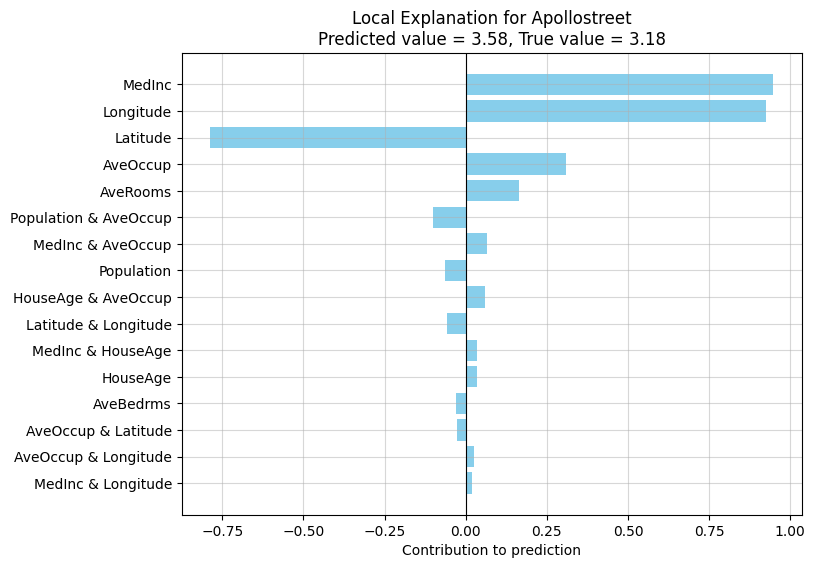

In [260]:
# (local) feature importance

dict_model_houses = dict(zip(list_model_houses, range(9)))
local_exp = ebm_model.explain_local(X_test_houses, y_test_houses)
idx = dict_model_houses[dropdown_house.value]

instance_local = local_exp.data(idx)

feature_names = instance_local['names'] 
contributions = instance_local['scores']

# Compute predicted value as sum of contributions (if you want it)
predicted_value = ebm_model.predict(
    pd.DataFrame(X_test_houses.iloc[idx]).transpose()
)

# Sort contributions for plotting
sorted_idx = np.argsort(np.abs(contributions))
sorted_features = np.array(feature_names)[sorted_idx]
sorted_contribs = np.array(contributions)[sorted_idx]

# Plot waterfall-like chart
plt.figure(figsize=(8,6))
plt.barh(sorted_features, sorted_contribs, color='skyblue')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.title(f'Local Explanation for {dropdown_house.value}\nPredicted value = {predicted_value[0]:.2f}, True value = {y_test_houses.iloc[idx]:.2f}')
plt.xlabel('Contribution to prediction')
plt.grid(alpha=0.5)
plt.show()

In [261]:
# Test with the URL version of the dataset – it is slightly different
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
df_url = pd.read_csv(url)
X_url = df_url.drop('median_house_value', axis=1)
y_url = df_url['median_house_value']
X_train_url, x_, y_train_url, y_ = train_test_split(X_url, y_url, test_size=0.4, random_state=43)
X_train_url.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,12384.000000,12384.000000,12384.000000,12384.000000,12260.000000,12384.000000,12384.000000,12384.000000
mean,-119.597476,35.656814,28.747255,2613.497012,534.194780,1416.009367,496.297077,3.861783
std,2.008204,2.137167,12.613932,2143.903406,415.701518,1084.064300,376.962706,1.895800
min,-124.350000,32.540000,1.000000,6.000000,2.000000,5.000000,2.000000,0.499900
25%,-121.830000,33.940000,18.000000,1441.000000,294.000000,779.000000,277.000000,2.554050
50%,-118.520000,34.270000,29.000000,2105.000000,431.000000,1160.000000,407.000000,3.533100
75%,-118.020000,37.730000,37.000000,3149.250000,647.000000,1720.000000,603.000000,4.730800
max,-114.310000,41.920000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100
